# Running MATILDA for the training period

- create settings.yaml (here or in the other Notebooks)
- run MATILDA with default parameters
- (split in calibration and validation samples)
- run mspot with few iterations
- write best parameter set to yaml
- run matilda with best parameter set

Some helper functions to work with `yaml` and `pickle` files.

In [1]:
import yaml
import pickle

def read_yaml(file_path):
    """
    Read a YAML file and return the contents as a dictionary.
    Parameters
    ----------
    file_path : str
        The path of the YAML file to read.
    Returns
    -------
    dict
        The contents of the YAML file as a dictionary.
    """
    with open(file_path, 'r') as f:
        data = yaml.safe_load(f)
        return data


def write_yaml(data, file_path):
    """
    Write a dictionary to a YAML file.
    Parameters
    ----------
    data : dict
        The dictionary to write to a YAML file.
    file_path : str
        The path of the file where the YAML data shall be stored.
    Returns
    -------
    None
    """
    with open(file_path, 'w') as f:
        yaml.safe_dump(data, f)


def update_yaml(file_path, new_items):
    """
    Update a YAML file with the contents of a dictionary.
    Parameters
    ----------
    file_path : str
        The path of the YAML file to update.
    new_items : dict
        The dictionary of new key-value pairs to add to the existing YAML file.
    Returns
    -------
    None
    """
    data = read_yaml(file_path)
    data.update(new_items)
    write_yaml(data, file_path)
    
def pickle_to_dict(file_path):
    """
    Loads a dictionary from a pickle file at a specified file path.
    Parameters
    ----------
    file_path : str
        The path of the pickle file to load.
    Returns
    -------
    dict
        The dictionary loaded from the pickle file.
    """
    with open(file_path, 'rb') as f:
        dic = pickle.load(f)
    return dic

Read data required for MATILDA from the config file

In [2]:
import configparser
import ast

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get output dir and date range from config.ini
dir_input = config['FILE_SETTINGS']['DIR_INPUT']
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']
date_range = ast.literal_eval(config['CONFIG']['DATE_RANGE'])

Derive setup and modeling periods from the defined time period. Default is to use the first two years as spinup.

In [3]:
import pandas as pd

length_of_setup_period = 2

sim_start = pd.to_datetime(date_range[0]) + pd.DateOffset(years = length_of_setup_period)
set_up_end = sim_start - pd.DateOffset(days = 1)

dates = {'set_up_start': date_range[0],
        'set_up_end': str(set_up_end).split(' ')[0],        # remove hh:mm:ss
        'sim_start': str(sim_start).split(' ')[0],          # remove hh:mm:ss
        'sim_end': date_range[1]}

print(dates)

{'set_up_start': '1998-01-01', 'set_up_end': '1999-12-31', 'sim_start': '2000-01-01', 'sim_end': '2020-12-31'}


Append the dates to the settings.yml with stored catchment information.

In [4]:
update_yaml(dir_output + 'settings.yml', dates)

Check the remaining settings, append them to the settings file and load it as a dictionary.

In [5]:
remaining_settings = {"freq": "M",            # aggregation level of model outputs (D, M, Y)
                      "warn": False,          # show warnings of subpackages?
                      "plot_type": "all",     # interactive and/or non-interactive plots ('print', 'interactive', 'all')
                      "elev_rescaling": True  # 
                     }

update_yaml(dir_output + 'settings.yml', remaining_settings)

settings = read_yaml(dir_output + 'settings.yml')
glacier_profile = pd.read_csv(dir_output + 'glacier_profile.csv')
settings['glacier_profile'] = glacier_profile
print(settings)

{'area_cat': 295.51935296803777, 'area_glac': 31.81370047643339, 'ele_cat': 3293.491688025922, 'ele_dat': 3335.668840874115, 'ele_glac': 4001.8798828125, 'elev_rescaling': True, 'freq': 'M', 'lat': 42.18284387725055, 'plot_type': 'all', 'set_up_end': '1999-12-31', 'set_up_start': '1998-01-01', 'sim_end': '2020-12-31', 'sim_start': '2000-01-01', 'warn': False, 'glacier_profile':      Elevation      Area          WE  EleZone
0       1970.0  0.000000      0.0000     1900
1       2000.0  0.000000      0.0000     2000
2       2100.0  0.000000      0.0000     2100
3       2200.0  0.000000      0.0000     2200
4       2300.0  0.000000      0.0000     2300
..         ...       ...         ...      ...
156     4730.0  0.000023  20721.3700     4700
157     4740.0  0.000013  14450.2180     4700
158     4750.0  0.000006  10551.4730     4700
159     4760.0  0.000000      0.0000     4700
160     4780.0  0.000002   6084.7456     4700

[161 rows x 4 columns]}


# Run MATILDA with default parameters

Load forcing and obs data

In [6]:
era5 = pd.read_csv(dir_output + 'ERA5L.csv', usecols=['temp', 'prec', 'dt'])
era5.columns = ['T2', 'RRR', 'TIMESTAMP']

obs = pd.read_csv('input/' + 'obs_runoff_example.csv')

---
MATILDA framework
Reading parameters for MATILDA simulation
Parameter set:
set_up_start     1998-01-01
set_up_end       1999-12-31
sim_start        2000-01-01
sim_end          2020-12-31
freq                      M
freq_long           Monthly
lat               42.182844
area_cat         295.519353
area_glac           31.8137
ele_dat         3335.668841
ele_cat         3293.491688
ele_glac        4001.879883
ele_non_glac    3208.031063
hydro_year               10
soi                    None
warn                  False
pfilter                   0
lr_temp              -0.006
lr_prec                   0
TT_snow                   0
TT_rain                   2
TT_diff                   2
CFMAX_snow              2.5
CFMAX_ice                 5
CFMAX_rel                 2
BETA                    1.0
CET                    0.15
FC                      250
K0                    0.055
K1                    0.055
K2                     0.04
LP                      0.7
MAXBAS                  3

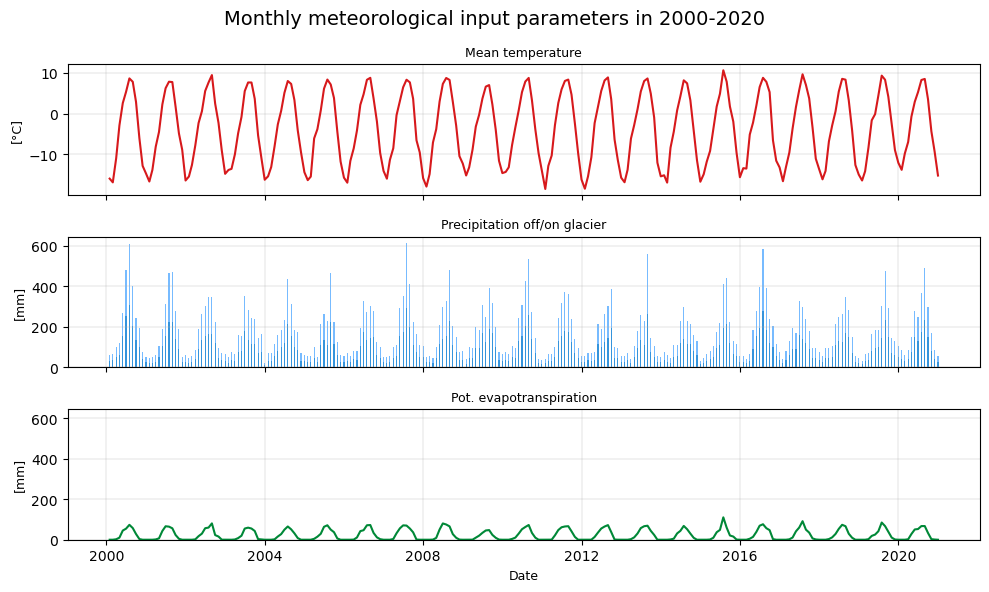

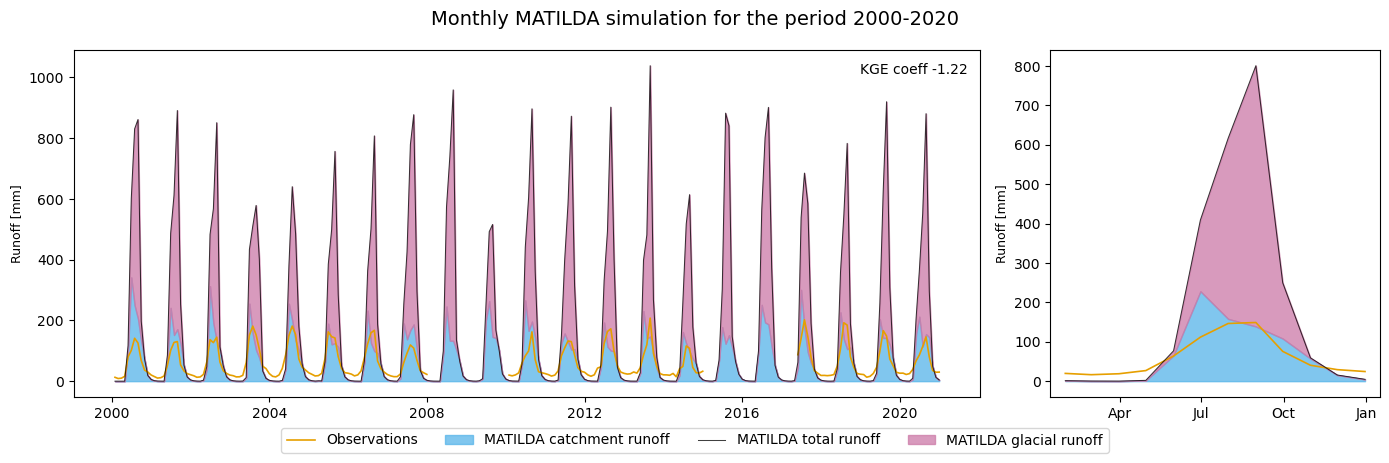

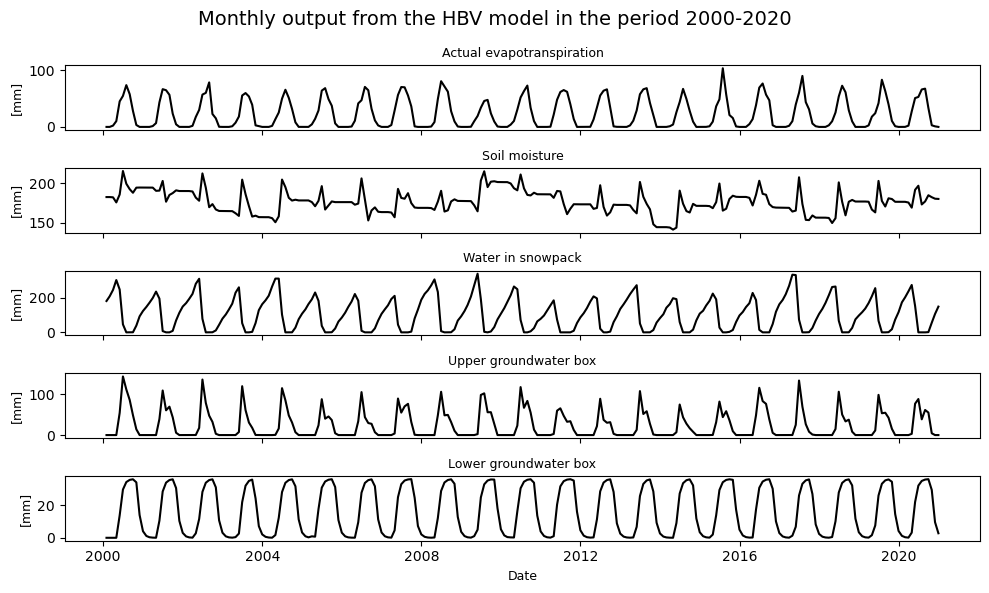

In [7]:
from matilda.core import matilda_simulation

output_matilda = matilda_simulation(era5, obs, **settings)

This is obviously an incorrect result so the model requires calibration.

In [8]:
param_dict = param = {'lr_temp': -0.006715786655857773,
 'lr_prec': 0.0009426868309736729,
 'BETA': 4.755073554352201,
 'CET': 0.07412818445635777,
 'FC': 424.03083598449393,
 'K0': 0.24661844658100276,
 'K1': 0.013814926672937655,
 'K2': 0.01877384431953609,
 'LP': 0.7699373762379815,
 'MAXBAS': 2.911911446589711,
 'PERC': 1.7425269942489015,
 'UZL': 392.21464659707215,
 'PCORR': 0.796841923720716,
 'TT_snow': -0.46045194130701805,
 'TT_diff': 1.7514302424196948,
 'CFMAX_ice': 7.7265119371929885,
 'CFMAX_rel': 1.6284621286938152,
 'SFCF': 0.989796885705358,
 'CWH': 0.17529112240136024,
 'AG': 0.5942337539192579,
 'RFS': 0.14722479457349263}

---
MATILDA framework
Reading parameters for MATILDA simulation
Parameter set:
set_up_start     1998-01-01
set_up_end       1999-12-31
sim_start        2000-01-01
sim_end          2020-12-31
freq                      M
freq_long           Monthly
lat               42.182844
area_cat         295.519353
area_glac           31.8137
ele_dat         3335.668841
ele_cat         3293.491688
ele_glac        4001.879883
ele_non_glac    3208.031063
hydro_year               10
soi                    None
warn                  False
pfilter                   0
lr_temp           -0.006716
lr_prec            0.000943
TT_snow           -0.460452
TT_rain            1.290978
TT_diff             1.75143
CFMAX_snow         4.744668
CFMAX_ice          7.726512
CFMAX_rel          1.628462
BETA               4.755074
CET                0.074128
FC               424.030836
K0                 0.246618
K1                 0.013815
K2                 0.018774
LP                 0.769937
MAXBAS             2.9119

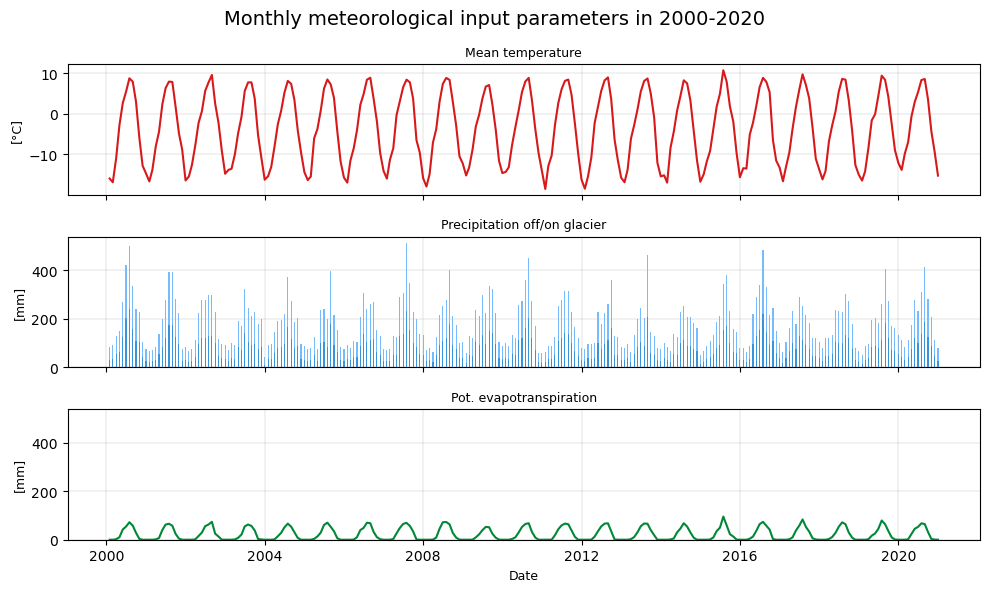

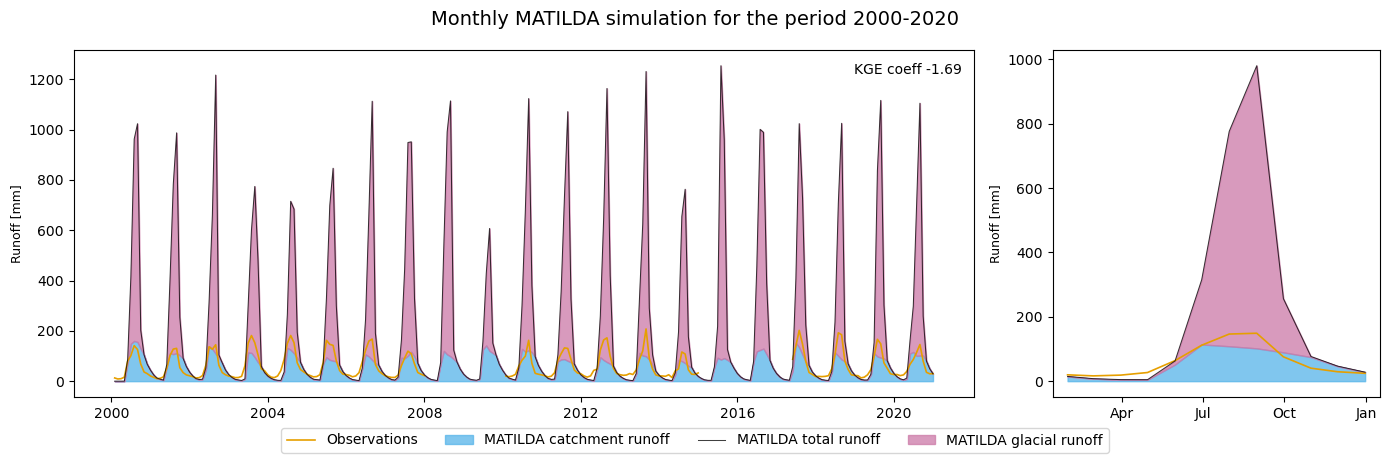

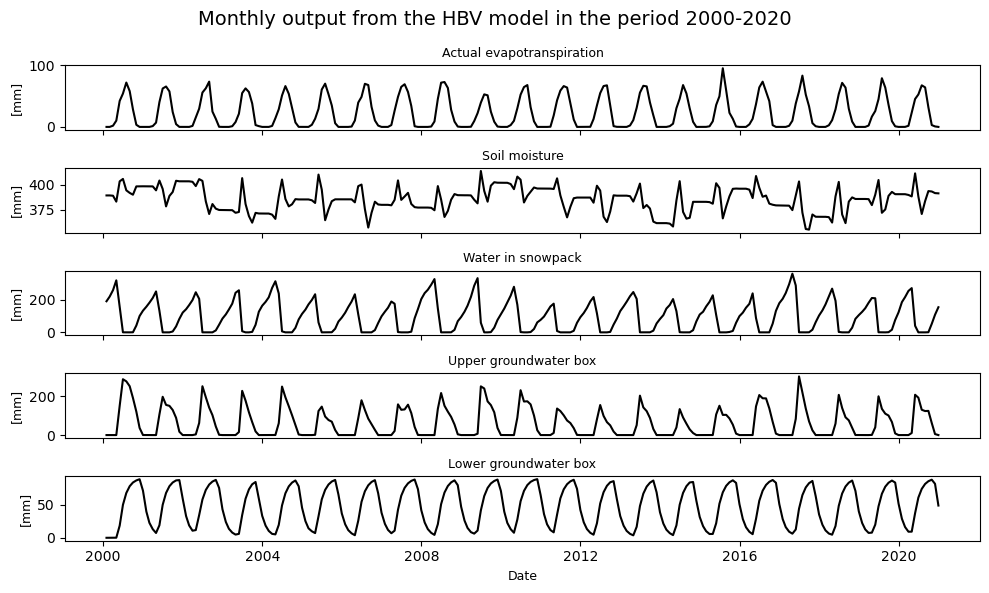

In [9]:
output_matilda = matilda_simulation(era5, obs, **settings, parameter_set = param_dict)

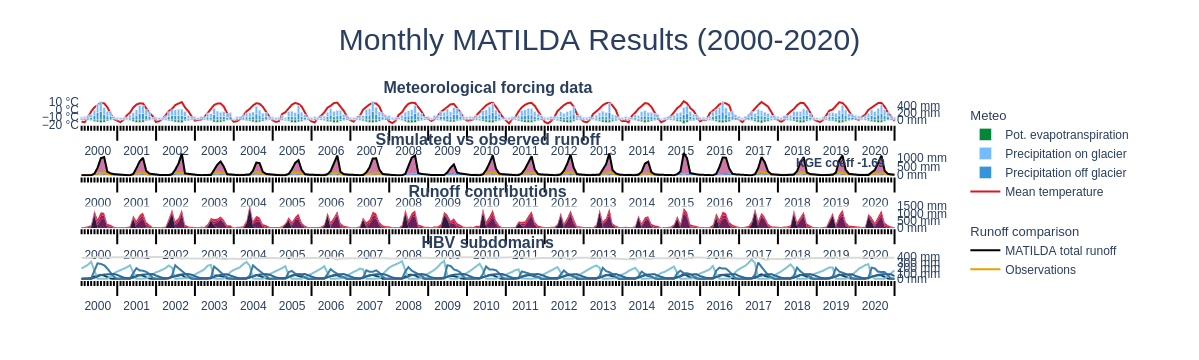

In [10]:
output_matilda[9].show()

# Calibrate MATILDA using the SPOTPY library

In [11]:
from matilda.mspot_glacier import psample

The default parameter boundaries of the `mspot()` function uses can be found in the MATILDA documentation. If you want to narrow down the parameter space you can do that using the following syntax.

In [12]:
lr_temp_lo = -0.007; lr_temp_up = -0.005

PCORR_lo_era = 0.29; PCORR_up_era = 1.2

lim_dict = {'lr_temp_lo': lr_temp_lo, 'lr_temp_up': lr_temp_up, 'PCORR_lo': PCORR_lo_era, 'PCORR_up': PCORR_up_era}

#best_summary = psample(df=era5, obs=obs, rep=10, #output=output_path + '/glacier_only',
                                    **dates, freq="D",
                                     area_cat=295.51935296803777, area_glac=31.81370047643339, lat=42.33,
                                     ele_dat=3335.668840874115, ele_cat=3293.491688025922, ele_glac=4001.8798828125,
                                     glacier_profile=glacier_profile, elev_rescaling=True,
                                     glacier_only=False,
                                     obj_dir="maximize",
                                    **lim_dict,
                                     #target_mb=-156,
                                     parallel=False, dbformat=None, algorithm='lhs', #cores=20,
                                     dbname='era5_matilda_edu_test')

IndentationError: unexpected indent (1729450289.py, line 8)

In addition to runoff we will use glacier mass balance as second calibration variable. [Shean et. al. 2020 ](https://doi.org/10.3389/feart.2019.00363) calculated robust geodetic mass balances for all glaciers in High Mountain Asia so will use their data set so derive a target mass balance for our catchment.

We pick all individual mass balances that match the glacier IDs in our catchment and calculate the mean. In addition, we use the uncertainty measures listed in the dataset to derive an uncertainty range.

In [3]:
import pandas as pd

mass_balances = pd.read_csv(dir_input + '/hma_mb_20190215_0815_rmse.csv', usecols=['RGIId', 'mb_mwea', 'mb_mwea_sigma'])
ids = pd.read_csv(dir_output + '/RGI/Glaciers_in_catchment.csv')

merged = pd.merge(mass_balances, ids, on='RGIId')
mean_mb = round(merged['mb_mwea'].mean() * 1000, 3)   # Mean catchment MB in mm w.e.
mean_sigma = round(merged['mb_mwea_sigma'].mean() * mean_mb, 3)  # Mean uncertainty of catchment MB in mm w.e.

target_mb = [mean_mb - mean_sigma, mean_mb + mean_sigma]

print('Target glacier mass balance for calibration: ' + str(mean_mb) + ' +-' + str(mean_sigma) + )

Target glacier mass balance for calibration: -155.474 +--50.3


# Run MATILDA with calibrated parameters

Pass best parameter set from calibration runs as dictionary.